# Example with [VEDAI dataset](https://downloads.greyc.fr/vedai/)

Here is an example of how to use the tool to export VEDAI dataset.

Assuming that the dataset of 512x512 images is downloaded on the disk, I write a helper class to easily access the files within a fold

In [1]:
from pathlib import Path

DATA_PATH = (Path("/") / "media" / "user" / "fast_storage" / "vedai" / "datasets" / "512x512" ).absolute()

!ls {DATA_PATH.as_posix()}

Annotations512	Annotations512.tar  Vehicules512


In [2]:
class VedaiFiles512x512:
    
    def __init__(self, path, img_type='co'):
        path = Path(path)
        assert img_type in ('co', 'ir')
        assert path.exists()
        self.path = path
        self.img_type = img_type
        targets = [t for t in (DATA_PATH / "Annotations512").glob("0*.txt")]
        self.targets = dict([(t.stem, t.as_posix()) for t in targets])
        self.images = dict([(t.stem, (DATA_PATH / "Vehicules512" / (t.stem + "_{}.png".format(self.img_type) ) ).as_posix())
                       for t in targets])
        for fp in self.images.values():
            assert Path(fp).exists(), "{} is not found".format(fp)
        self.ids = sorted(self.targets)
        
        self.n_folds = 10
        self.classes = {
            1: "car",
            2: "truck",            
            4: "tractor",
            5: "camping car",
            23: "boat",
            7: "Y",
            8: "X",
            9: "van",
            10: "other",
            11: "pickup",
            31: "large"
        }
                                
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        return self.images[index], self.targets[index]
        
    def _get_fold_indices(self, fold_index, mode):        
        fp = self.path / "Annotations512" / "fold{:02}{}.txt".format(fold_index, mode)
        assert fp.exists()
        indices = []
        with fp.open('r') as handle:
            while True:
                line = handle.readline()
                if len(line) == 0:
                    break
                indices.append(line[:-1])
        return indices        
    
    def get_train_test_indices(self, fold_index):
        assert fold_index >= 1 and fold_index <= self.n_folds
        train_indices = self._get_fold_indices(fold_index, mode='')
        test_indices = self._get_fold_indices(fold_index, mode='test')
        assert set(test_indices) & set(train_indices) == set()
        return train_indices, test_indices
    
    def parse_target(self, target_str):
        splt = target_str.split(' ')
        assert len(splt) == 14, "{}".format(target_str)
        output = {
            "coords": [float(v) for v in splt[0:3]],
            "class_id": int(splt[3]),
            "is_fully_visible": bool(splt[4]),
            "is_occluded": bool(splt[5]),
            "bbox": [(int(splt[i]), int(splt[i + 4])) for i in range(6, 10)]            
        }        
        return output
    
    def get_parsed_target(self, index):
        output = []
        with Path(self.targets[index]).open('r') as handle:
            while True:
                line = handle.readline()
                if len(line) == 0:
                    break
                output.append(self.parse_target(line[:-1]))
        return output

In [3]:
ds = VedaiFiles512x512(DATA_PATH, img_type='co')
len(ds)

1246

Dataset is composed of 1246 samples. Here is a single sample files:

In [4]:
ds[ds.ids[0]]

('/media/user/fast_storage/vedai/datasets/512x512/Vehicules512/00000000_co.png',
 '/media/user/fast_storage/vedai/datasets/512x512/Annotations512/00000000.txt')

In [5]:
from PIL import Image
import matplotlib.pylab as plt
%matplotlib inline

from pathlib import Path
import sys

root_path = Path("..").absolute()
if root_path.as_posix() not in sys.path:
    sys.path.append(root_path.as_posix())

from image_dataset_viz import DatasetExporter

Let's create a list of image files and target points with labels

In [6]:
import numpy as np

img_files = [ds[i][0] for i in ds.ids]
targets = []

for i in ds.ids:
    ts = ds.get_parsed_target(i)
    pts_labels = []
    for t in ts:
        pts_labels.append((np.array(t['bbox']), ds.classes[t['class_id']]))
    targets.append(pts_labels)

(256, 256)


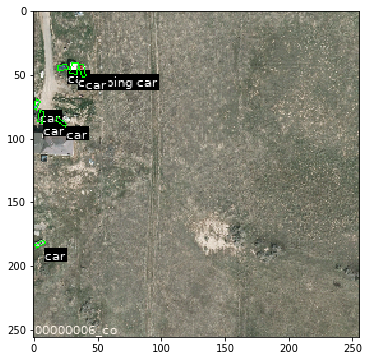

In [7]:
from image_dataset_viz import DatasetExporter

de = DatasetExporter(n_cols=20, text_size=10)
de.export_datapoint(img_files[5], targets[5], "test.png")

plt.figure(figsize=(12, 6))
img = Image.open("test.png")
plt.imshow(img)
print(img.size)

Now, let's export the whole dataset

In [8]:
de.export(img_files, targets, output_folder="vedai_viz")

100%|##########|1246/1246[00:32<00:00,38.02it/s]


In [9]:
!ls -R vedai_viz/ | wc -l

3


In [10]:
out_img = Image.open("vedai_viz/dataset_part_0.png")
out_img.size

(5220, 13050)

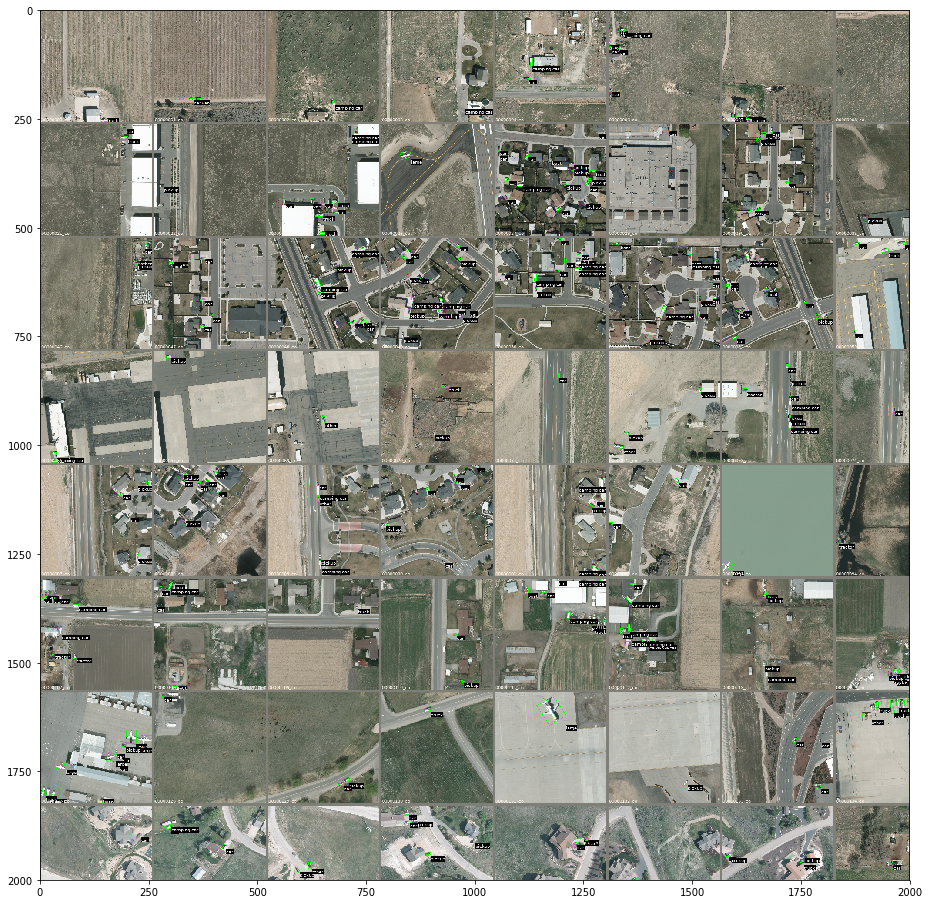

In [11]:
img = out_img.crop((0, 0, 2000, 2000))
plt.figure(figsize=(16, 16))
plt.imshow(img)

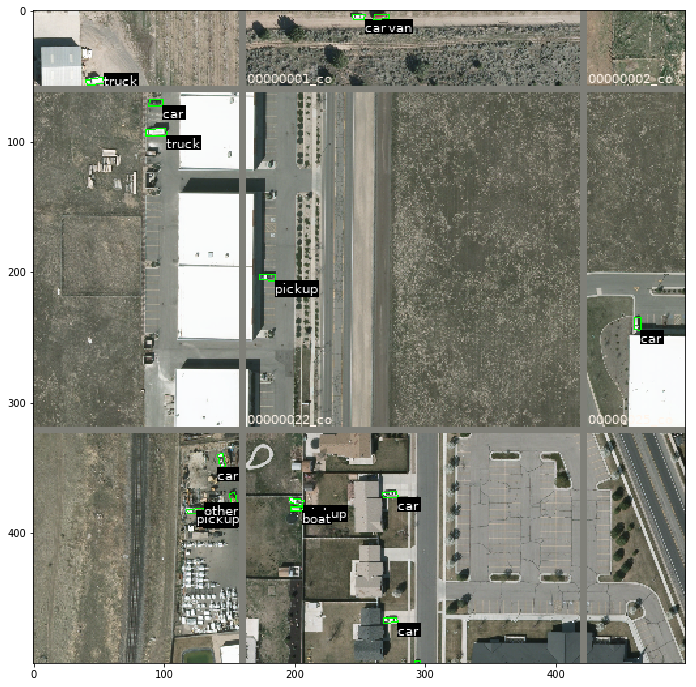

In [12]:
img = out_img.crop((100, 200, 600, 700))
plt.figure(figsize=(12, 12))
plt.imshow(img)

In [13]:
!rm -R vedai_viz/
!rm test.png